In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
from scipy.stats import shapiro, levene, rankdata, linregress, kruskal
import helper

/gpfs1/home/c/p/cpetak/CA_GRN2/helper.py:164: NumbaPerformanceWarning: np.dot() is faster on contiguous arrays, called on (Array(float64, 2, 'A', False, aligned=True), Array(float64, 2, 'A', False, aligned=True))
  next_step = windows.dot(grn)
/gpfs1/home/c/p/cpetak/CA_GRN2/helper.py:185: NumbaPerformanceWarning: np.dot() is faster on contiguous arrays, called on (Array(float64, 2, 'C', False, aligned=True), Array(float64, 2, 'A', False, aligned=True))
  next_step = gene_vals.dot(internal_grn)


In [5]:
root="~/scratch/detailed_save/"
metric1 = "beststd"
metric2 = "best_grn_std"
num_reps = 15
season_len=300
id_start = 0
seed_ints = [69904,149796]
grn_size = 22

rules = [22, 126, 154, 18, 122, 70,54,94,30,50,62,110,90,150,102]
rules = [54] #22,54,102 pretty high, 126,122,70,150 low, 154,18,94,30,62,110,90 medium

for rule in rules:
    print(rule)
    std_vals=[np.loadtxt(os.path.expanduser(root+f"variable/stats_{season_len}_{rule}-{rule}_69904-149796_{i+1+id_start}_{metric1}.txt")) for i in range(num_reps)]
    std_vals = np.array(std_vals)
    print(std_vals.shape)

for rule in rules:
    print(rule)
    std_grns=[np.loadtxt(os.path.expanduser(root+f"variable/stats_{season_len}_{rule}-{rule}_69904-149796_{i+1+id_start}_{metric2}.txt")) for i in range(num_reps)]
    std_grns = np.array(std_grns)
    std_grns = np.reshape(std_grns, (num_reps, 9898,grn_size+2,grn_size))
    print(std_grns.shape)

54
(15, 9898)
54
(15, 9898, 24, 22)


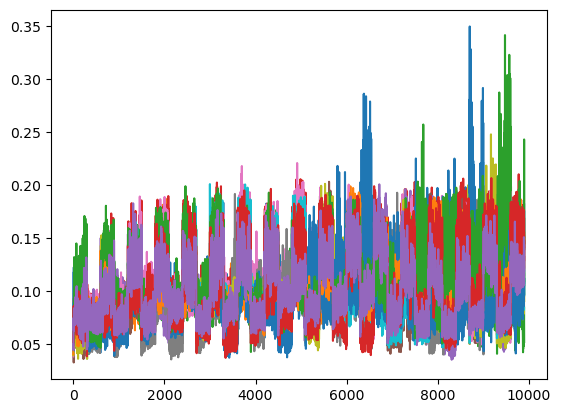

In [6]:
for i in range(num_reps):
    plt.plot(std_vals[i])

In [27]:
def make_heatmap(rep, gen):
    grn_to_test = std_grns[rep, gen, :, :]

    #create pop of kids
    num_clones = 10_000
    seasons = np.tile(np.repeat([0, 1], 300), 100)
    kids = np.repeat(grn_to_test[np.newaxis, :, :], num_clones, axis=0)

    #mutate all
    mut_rate = 0.1
    mut_size = 0.5
    num_genes_mutate = int((grn_size + 2) * grn_size * num_clones * mut_rate)
    np.random.seed(44)
    mutations = np.random.randn(num_genes_mutate) * mut_size
    x, y, z = kids.shape
    xs = np.random.choice(x, size=num_genes_mutate)
    ys = np.random.choice(y, size=num_genes_mutate)
    zs = np.random.choice(z, size=num_genes_mutate)
    kids[xs, ys, zs] = kids[xs, ys, zs] + mutations

    #calc phenos
    num_cells = 22
    dev_steps = 22
    inputs = []
    seeds = []
    for seed_int in seed_ints:
        #Make seeds, 1024 is one-hot
        start_pattern = helper.seedID2string(seed_int, num_cells)
        seeds.append(start_pattern)
        start_expression = helper.seed2expression(start_pattern, num_clones, num_cells, grn_size, geneid=1)
        inputs.append(start_expression)

    targets = []
    for idx, seed in enumerate(seeds):
        targets.append(helper.rule2targets_wrapped_wstart(int(rule), L=dev_steps+1, N=num_cells, start_pattern=seed))

    #parent pheno
    curr = seasons[gen]
    print(curr)
    parent_pheno = helper.develop(inputs[curr], np.expand_dims(grn_to_test, axis=0), dev_steps, 1, grn_size, num_cells)

    #kids pheno
    phenos = helper.develop(inputs[curr], kids, dev_steps, num_clones, grn_size, num_cells)
    #print(kids.shape, phenos.shape)
    p=phenos[:,:,1::grn_size]
    #print(p.shape)
    per_cell_std = np.std(p, axis = 0)
    fitnesses1 = helper.fitness_function_ca(p, targets[0])
    fitnesses2 = helper.fitness_function_ca(p, targets[1])
    worst= -num_cells*dev_steps
    fitnesses1=1-(fitnesses1/worst)
    fitnesses2=1-(fitnesses2/worst)

    parent_fit1 = helper.fitness_function_ca(parent_pheno[:,:,1::grn_size], targets[0])
    parent_fit2 = helper.fitness_function_ca(parent_pheno[:,:,1::grn_size], targets[1])
    parent_fit1=1-(parent_fit1/worst)
    parent_fit2=1-(parent_fit2/worst)

    #get pheno variation
    where_overlap = np.where(targets[0]==targets[1])
    where_no_overlap = np.where(targets[0]!=targets[1])

    values_they_should_match = p[:,where_overlap[0],where_overlap[1]]
    matching_std = np.std(values_they_should_match, axis=0)
    matching_std = matching_std.mean(axis=0) #average across the N overlaps, to get 1 value for each parent
    #print(matching_std)

    #repeat for non-overlap
    values_they_shouldnt_match = p[:,where_no_overlap[0],where_no_overlap[1]]
    nonmatching_std = np.std(values_they_shouldnt_match, axis=0)
    nonmatching_std = nonmatching_std.mean(axis=0)
    #print(nonmatching_std)

    #minimum std is 0, max is 0.5 in the case of values that range between 0 and 1
    combined_std = nonmatching_std - matching_std
    
    return parent_pheno, per_cell_std, combined_std, targets, fitnesses1, fitnesses2, parent_fit1, parent_fit2




In [28]:
rep, gen = np.unravel_index(np.argmax(std_vals), std_vals.shape)

In [52]:
all_gens = np.arange(0,9899)
seasons = np.tile(np.repeat([0, 1], 300), 100)
season_len = 300
n_seasons = int(np.floor(9899/season_len))
chunked_gens = np.array([all_gens[i*season_len:(i+1)*season_len] for i in range(n_seasons)])
chunked_gens[1::2]

array([[ 300,  301,  302, ...,  597,  598,  599],
       [ 900,  901,  902, ..., 1197, 1198, 1199],
       [1500, 1501, 1502, ..., 1797, 1798, 1799],
       ...,
       [8100, 8101, 8102, ..., 8397, 8398, 8399],
       [8700, 8701, 8702, ..., 8997, 8998, 8999],
       [9300, 9301, 9302, ..., 9597, 9598, 9599]])

In [81]:
flat_indices = np.argsort(std_vals, axis=None)  # Get the indices of the top 10 values

# Convert the flat indices to 2D coordinates (row, column)
top_coords = np.unravel_index(flat_indices, std_vals.shape)

rep = top_coords[0][-1]
gen = top_coords[1][-1]

rep, gen

(10, 8702)

In [83]:
rep, gen

(10, 8702)

In [84]:
cstds=[]
for g in [gen]:
    parent_pheno, per_cell_std, combined_std, targets,f1,f2,pf1,pf2 = make_heatmap(rep, g)
    cstds.append(combined_std)
    #print(combined_std, std_vals[rep,g])
    #plt.imshow(parent_pheno[:,:,1::grn_size][0])
    #plt.show()

1


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


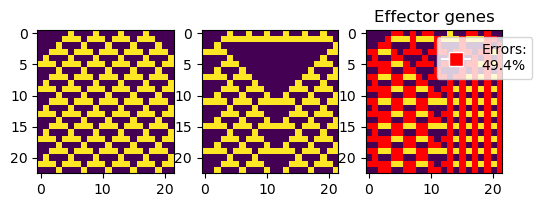

In [85]:
fig, axs = plt.subplots(ncols=3, figsize=(6, 4))
#Plot best phenotype
axs[0].imshow(targets[0])
#Plot target
axs[1].imshow(targets[1])
#Plot difference
helper.show_effectors(targets[0], targets[1], M=0, ax=axs[2])
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


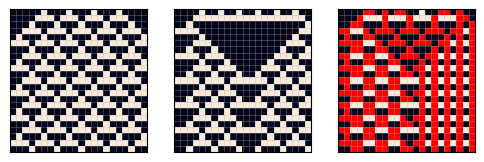

In [86]:
import seaborn as sns
from matplotlib.lines import Line2D

fig, axs = plt.subplots(ncols=3, figsize=(6, 4))

preds = np.where(targets[0] > 0.5, 1, 0)
correct = np.where(np.abs(targets[1] - preds) > 0, 1, 0)
correct_mask = np.ma.array(targets[1], mask=correct)
reds = np.dstack(
    [np.ones_like(targets[1]) * 255, np.zeros_like(targets[1]), np.zeros_like(targets[1])]
)

# Create the figure
axs[2].imshow(reds, label="errors")  # red background
#plt.imshow(correct_mask)

# a bit of a mindfuck, correct is used as a mask so it's like the inverse... xD
error_perc = correct.sum() / targets[1].size * 100

helper.imshow_ca(targets[0], ax=axs[0])
helper.imshow_ca(targets[1], ax=axs[1])
helper.imshow_ca(correct_mask, ax=axs[2])


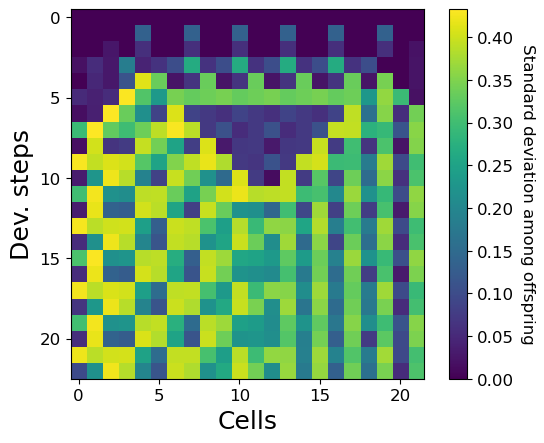

In [87]:
plt.imshow(per_cell_std)
cbar=plt.colorbar()
plt.xlabel("Cells", fontsize=18)
plt.ylabel("Dev. steps", fontsize=18)
#plt.legend(loc="upper right", prop={'size': 18})
plt.tick_params(axis='both', which='major', labelsize=12)
cbar.set_label('Standard deviation among offspring', fontsize=12)
cbar.ax.yaxis.label.set_rotation(270)  # Rotate label to the left
cbar.ax.yaxis.label.set_horizontalalignment('center')  # Align horizontally
cbar.ax.yaxis.label.set_verticalalignment('bottom')  # Align vertically
cbar.ax.tick_params(labelsize=12)
plt.show()

/users/c/p/cpetak/miniconda3/envs/ca_grn/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/users/c/p/cpetak/miniconda3/envs/ca_grn/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


(0.3, 1.0)

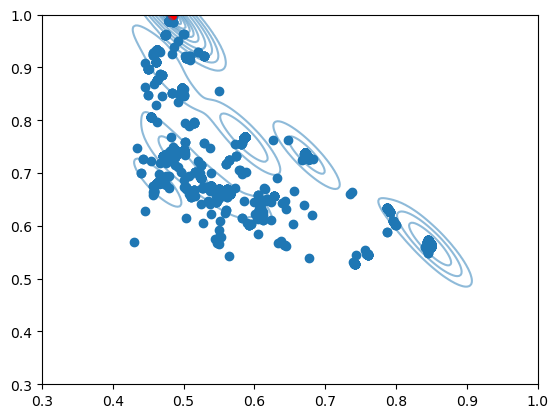

In [88]:
plt.scatter(f1,f2)
plt.scatter(pf1,pf2,color="red")
sns.kdeplot(x = f1, y = f2,fill=False,zorder=1,alpha=0.5)
plt.xlim(0.3,1)
plt.ylim(0.3,1)

In [39]:
pf1,pf2

(array([0.48347107]), array([1.]))

In [40]:
import pickle
pickle.dump(np.concatenate((f1,f2)), open(f"anal_saved_results/spec_pheno_{rule}.p", "wb" ) )


$r$ = 0.00, $p$ = nan


/users/c/p/cpetak/miniconda3/envs/ca_grn/lib/python3.11/site-packages/scipy/stats/_stats_mstats_common.py:182: RuntimeWarning: invalid value encountered in scalar divide
  slope = ssxym / ssxm
/users/c/p/cpetak/miniconda3/envs/ca_grn/lib/python3.11/site-packages/scipy/stats/_stats_mstats_common.py:196: RuntimeWarning: invalid value encountered in sqrt
  t = r * np.sqrt(df / ((1.0 - r + TINY)*(1.0 + r + TINY)))
/users/c/p/cpetak/miniconda3/envs/ca_grn/lib/python3.11/site-packages/scipy/stats/_stats_mstats_common.py:199: RuntimeWarning: invalid value encountered in scalar divide
  slope_stderr = np.sqrt((1 - r**2) * ssym / ssxm / df)


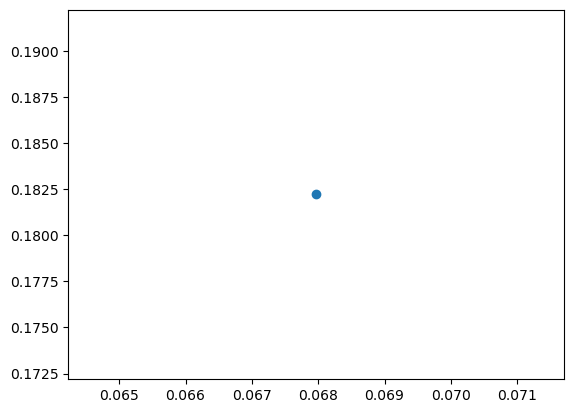

In [31]:
plt.scatter(cstds, std_vals[rep,g])
x =cstds
y= std_vals[rep,g]
slope, intercept, r_value, p_value, std_err = linregress(x, y)
x_fit = np.linspace(min(x), max(x), 100)
y_fit = slope * x_fit + intercept
plt.plot(x_fit, y_fit, color='red', linestyle='--', label=f'Fit: y = {slope:.2f}x + {intercept:.2f}')
print(f'$r$ = {r_value:.2f}, $p$ = {p_value}')

In [40]:
root="~/scratch/detailed_save/"
metric1 = "best_grn"
num_reps = 15
season_len=300
id_start = 0
seed_ints = [69904,149796]
grn_size = 22

rules = [22, 126, 154, 18, 122, 70,54,94,30,50,62,110,90,150,102]
rules = [102] #22,54,102 pretty high, 126,122,70,150 low, 154,18,94,30,62,110,90 medium

for rule in rules:
    print(rule)
    std_grns=[np.loadtxt(os.path.expanduser(root+f"variable/stats_{season_len}_{rule}-{rule}_69904-149796_{i+1+id_start}_{metric1}.txt")) for i in range(num_reps)]
    std_grns = np.array(std_grns)
    std_grns = np.reshape(std_grns, (num_reps, 9899,grn_size+2,grn_size))
    print(std_grns.shape)

102
(15, 9899, 24, 22)


In [41]:
def make_kids(grn_to_test, gen, mut_rate=1, mut_size=0.063):
    
    #create pop of kids
    num_clones = 100
    seasons = np.tile(np.repeat([0, 1], 300), 100)[:9899]
    kids = np.repeat(grn_to_test[np.newaxis, :, :], num_clones, axis=0)

    #mutate all
    num_genes_mutate = int((grn_size + 2) * grn_size * num_clones * mut_rate)
    #np.random.seed(44)
    mutations = np.random.randn(num_genes_mutate) * mut_size
    x, y, z = kids.shape
    xs = np.random.choice(x, size=num_genes_mutate)
    ys = np.random.choice(y, size=num_genes_mutate)
    zs = np.random.choice(z, size=num_genes_mutate)
    
    kids[xs, ys, zs] = kids[xs, ys, zs] + mutations

    #calc phenos
    num_cells = 22
    dev_steps = 22
    inputs = []
    seeds = []
    for seed_int in seed_ints:
        #Make seeds, 1024 is one-hot
        start_pattern = helper.seedID2string(seed_int, num_cells)
        seeds.append(start_pattern)
        start_expression = helper.seed2expression(start_pattern, num_clones, num_cells, grn_size, geneid=1)
        inputs.append(start_expression)

    targets = []
    for idx, seed in enumerate(seeds):
        targets.append(helper.rule2targets_wrapped_wstart(int(rule), L=dev_steps+1, N=num_cells, start_pattern=seed))

    #parent pheno
    curr = seasons[gen]
    parent_pheno = helper.develop(inputs[curr], np.expand_dims(grn_to_test, axis=0), dev_steps, 1, grn_size, num_cells)
    parent_pheno=parent_pheno[:,:,1::grn_size]

    #kids pheno
    phenos = helper.develop(inputs[curr], kids, dev_steps, num_clones, grn_size, num_cells)
    #print(kids.shape, phenos.shape)
    p=phenos[:,:,1::grn_size]

    worst= -num_cells*dev_steps
    prefitnesses = helper.fitness_function_ca(p, targets[curr])
    fitnesses=1-(prefitnesses/worst) #0-1 scaling

    parent_fit = helper.fitness_function_ca(parent_pheno, targets[curr])
    parent_fit=1-(parent_fit/worst) #0-1 scaling

    
    return parent_fit, fitnesses, kids



In [42]:
std_grns.shape

(15, 9899, 24, 22)

[1.]
[ 81 157]
[0.6595363628385522, 0.9972194573687994]


/users/c/p/cpetak/miniconda3/envs/ca_grn/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


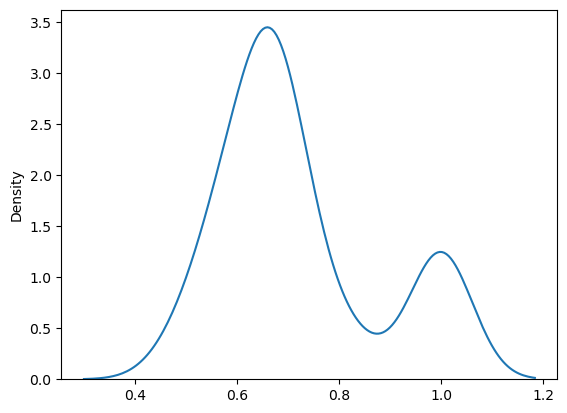

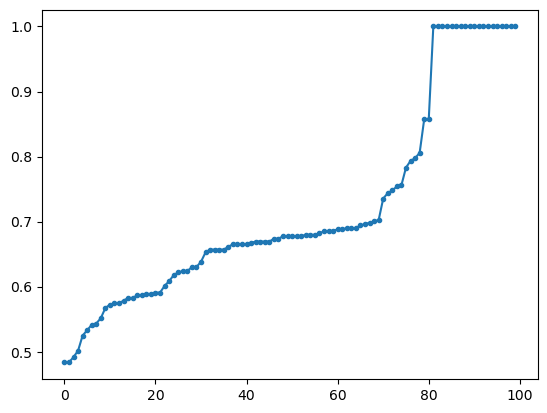

[13 20 23 28 31 37 52 56 58 75 79 81 92 95 97]
(24, 22)


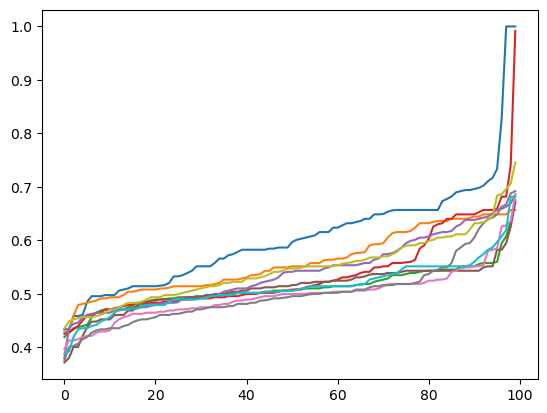

[0.95472277]
[ 71 105]
[0.5319927895069774, 0.6665308635683052]


/users/c/p/cpetak/miniconda3/envs/ca_grn/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


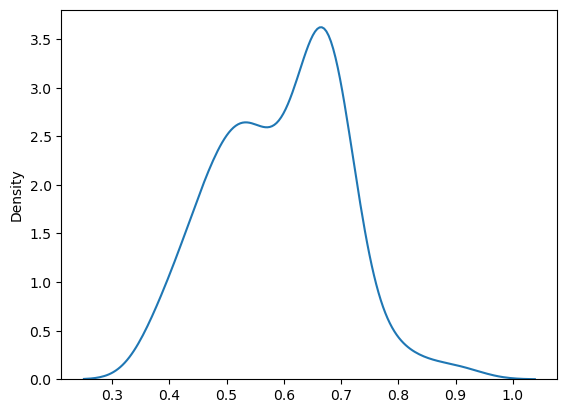

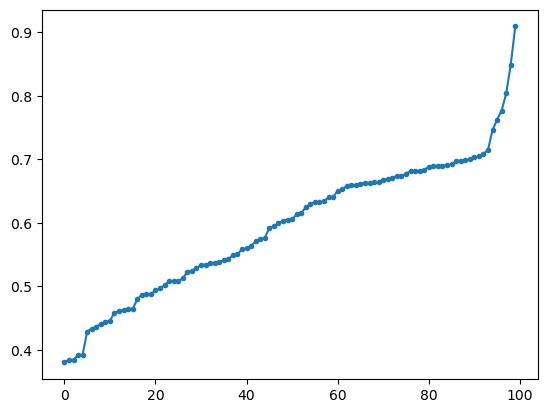

[ 0 10 15 44 46 57 61 70 95]
(24, 22)


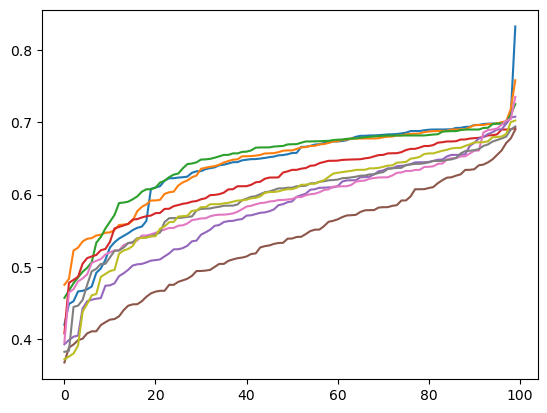

[1.]
[ 92 156]
[0.6603611330221442, 0.9933235417015001]


/users/c/p/cpetak/miniconda3/envs/ca_grn/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


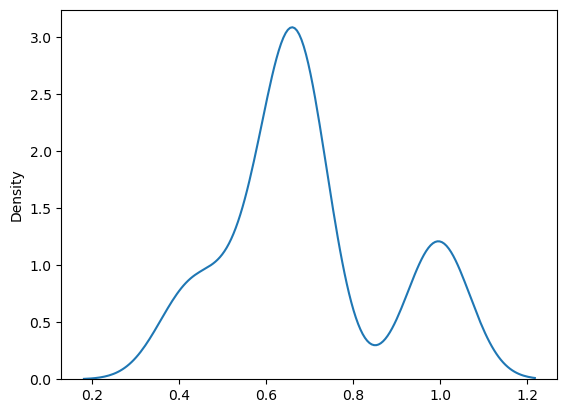

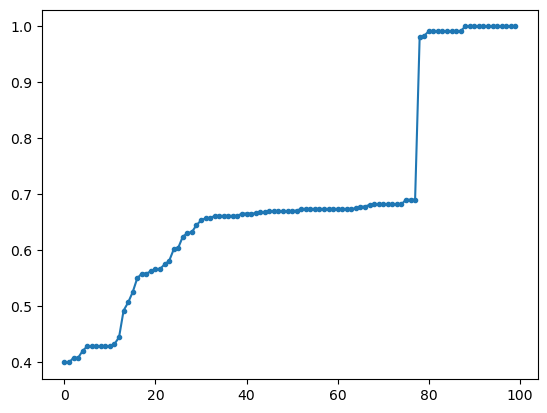

[ 3  5  6 13 14 26 35 39 48 50 51 54 61 74 75 83 91 94 95 96 97]
(24, 22)


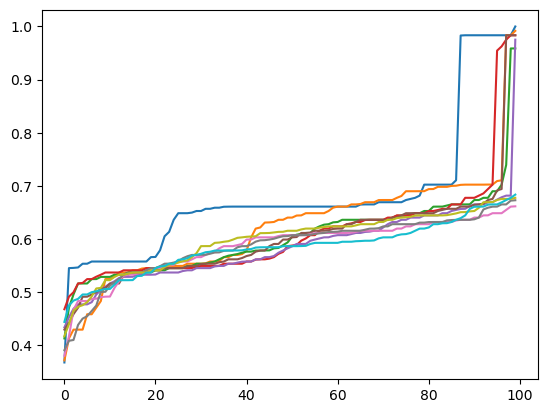

[0.77069732]
[ 89 125]
[0.5208536788820634, 0.6264499487337651]


/users/c/p/cpetak/miniconda3/envs/ca_grn/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


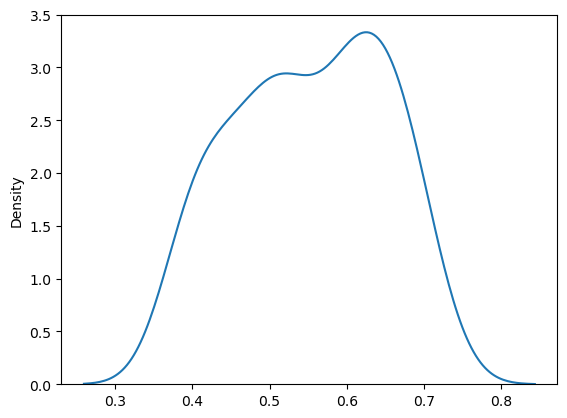

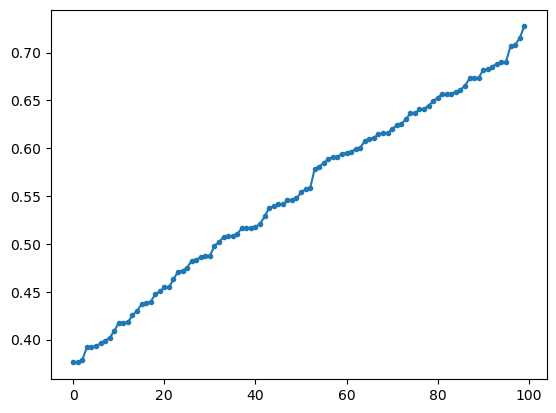

[ 0 27 36 49 84 86]
(24, 22)


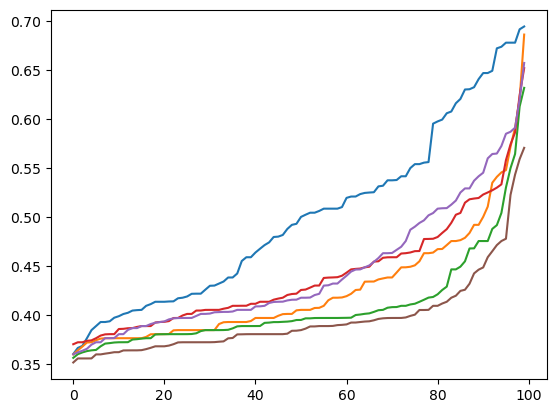

[0.78916144]
[ 26  73 147]
[0.3649579422638457, 0.4872760721868916, 0.6798620639806235]


/users/c/p/cpetak/miniconda3/envs/ca_grn/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


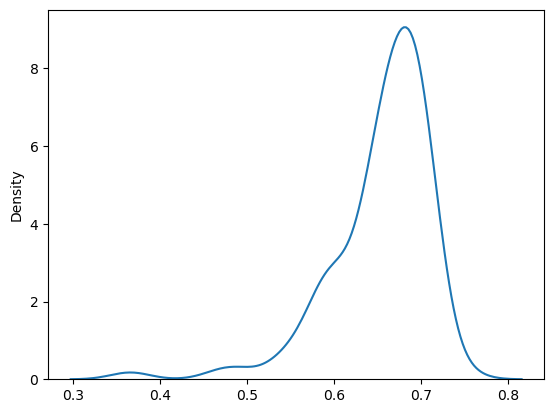

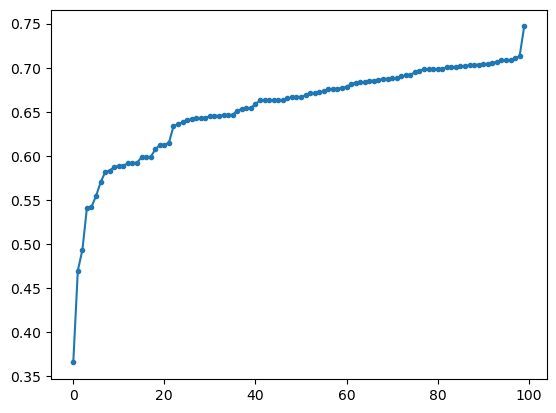

[62]
(24, 22)


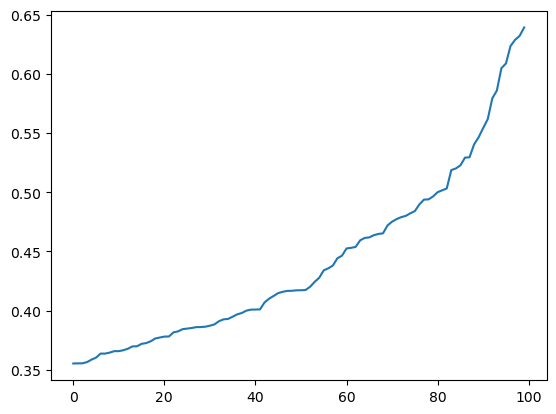

[0.95247934]
[ 79 125]
[0.6101291040967776, 0.8062008464181765]


/users/c/p/cpetak/miniconda3/envs/ca_grn/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


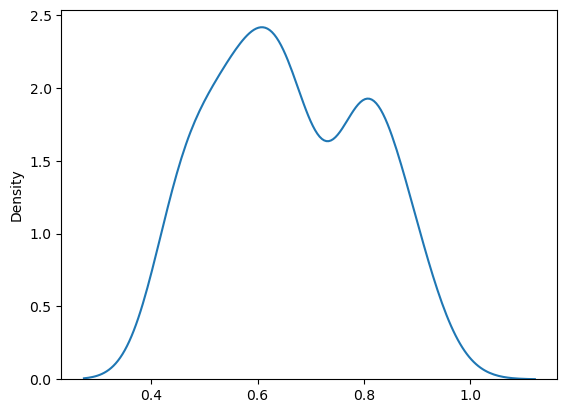

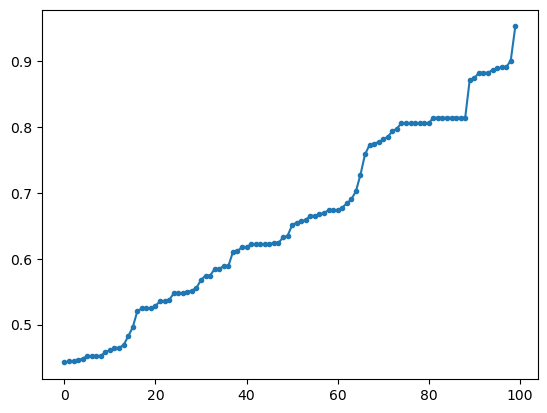

[ 8  9 48 89]
(24, 22)


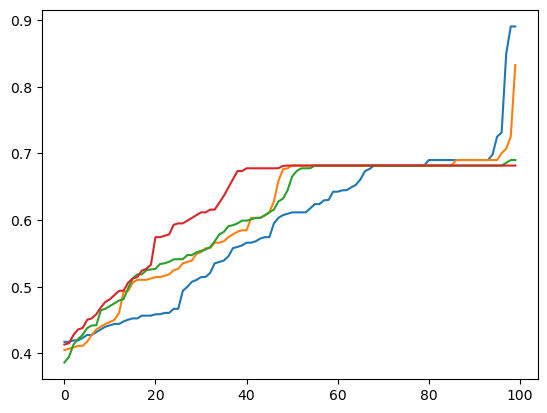

[0.81813906]
[137]
[0.6966572784293728]


/users/c/p/cpetak/miniconda3/envs/ca_grn/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


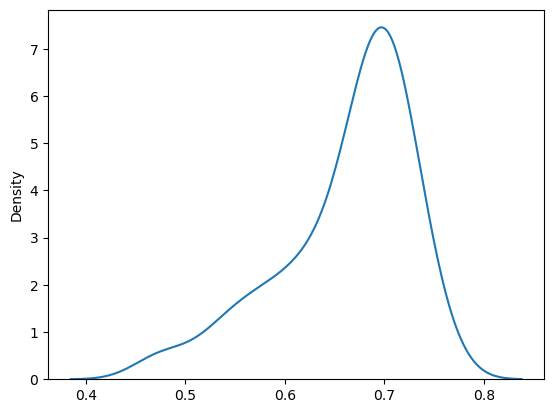

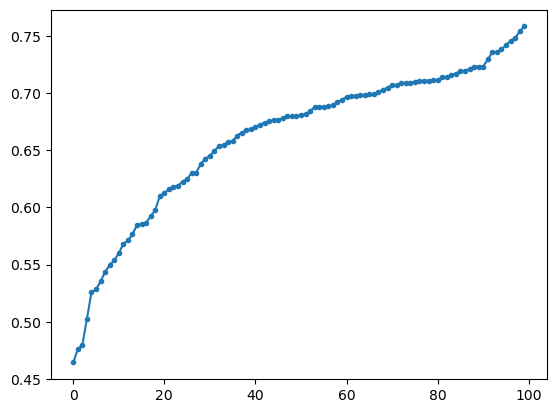

[ 1  6  9 11 12 16 21 29 36 41 60 68 69 80 83 85 86 88]
(24, 22)


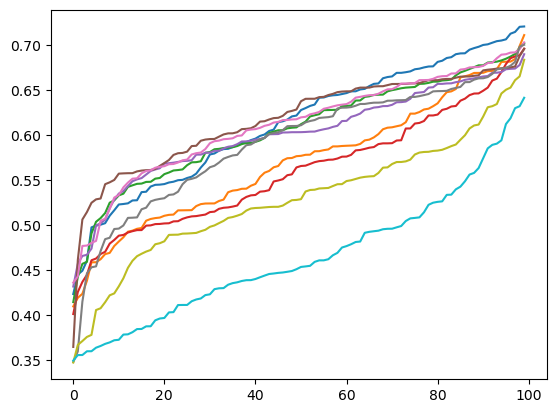

[0.81403465]
[ 34 148]
[0.41428302902493663, 0.6928336815337213]


/users/c/p/cpetak/miniconda3/envs/ca_grn/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


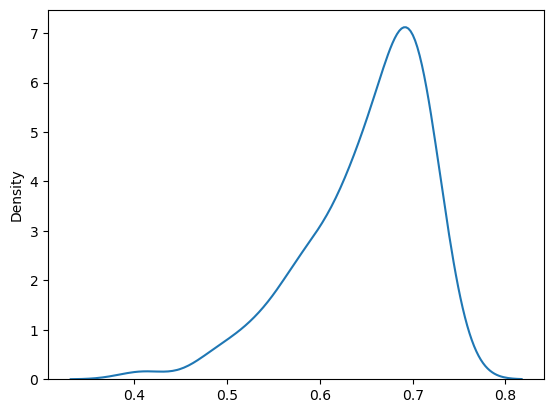

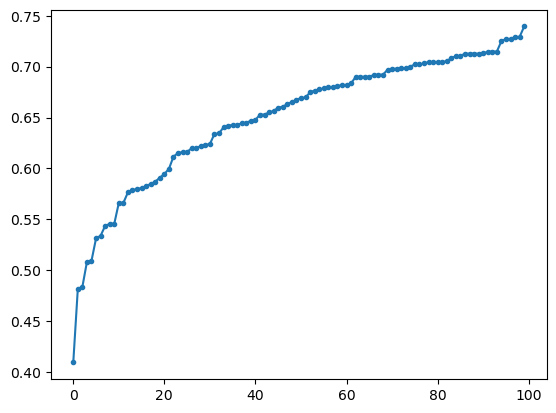

[31]
(24, 22)


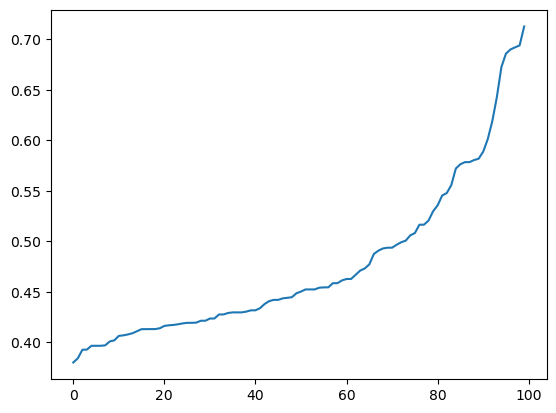

[0.82684872]
[ 34 133]
[0.43936472004812444, 0.66153544336935]


/users/c/p/cpetak/miniconda3/envs/ca_grn/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


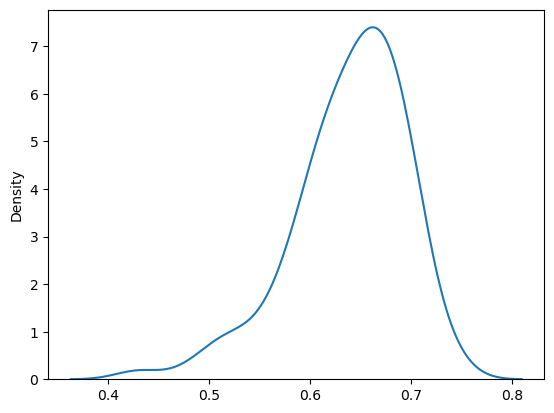

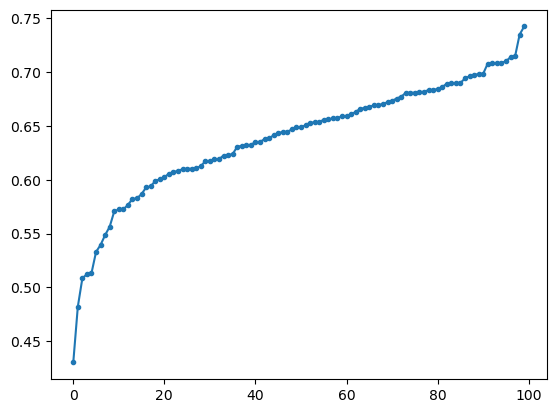

[99]
(24, 22)


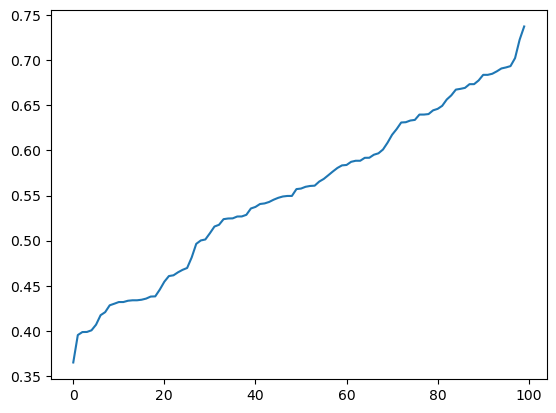

[1.]
[ 41  94 164]
[0.4360071213392873, 0.6612870244106437, 0.9588265190331898]


/users/c/p/cpetak/miniconda3/envs/ca_grn/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


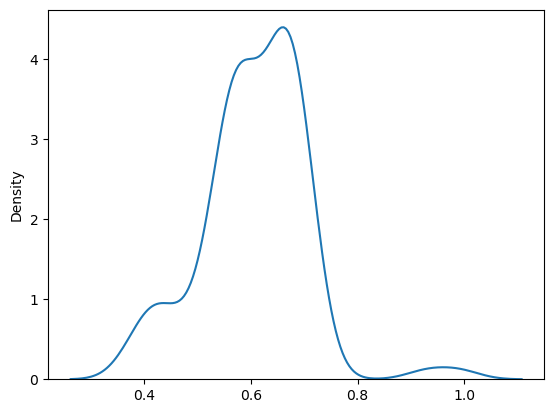

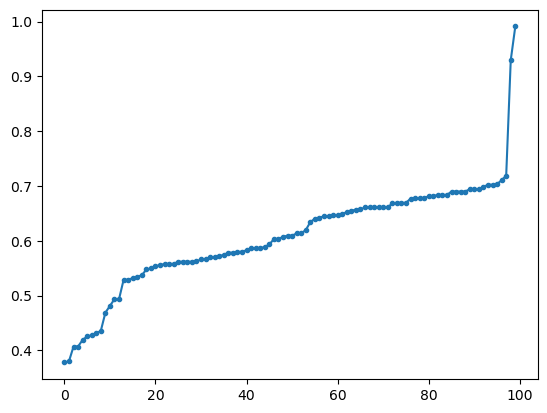

[10 27 97]
(24, 22)


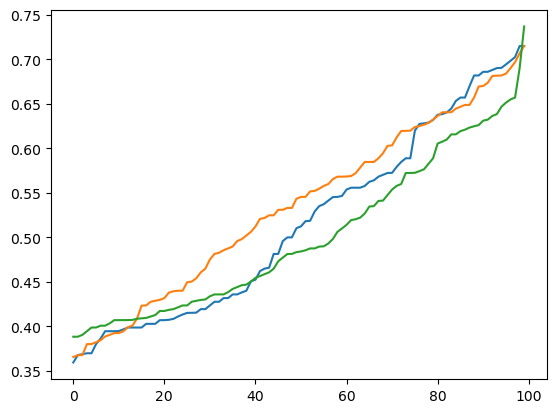

[0.94628099]
[ 77 161]
[0.5826973038548584, 0.9258327152563351]


/users/c/p/cpetak/miniconda3/envs/ca_grn/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


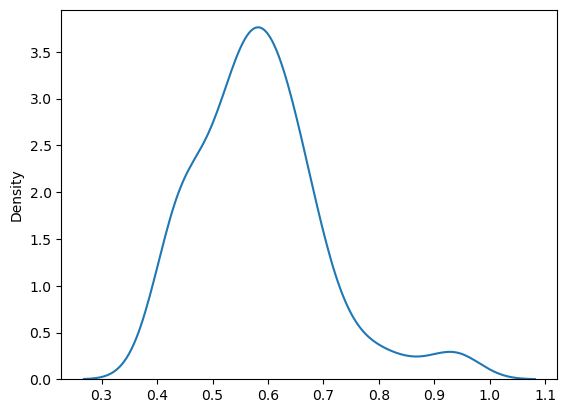

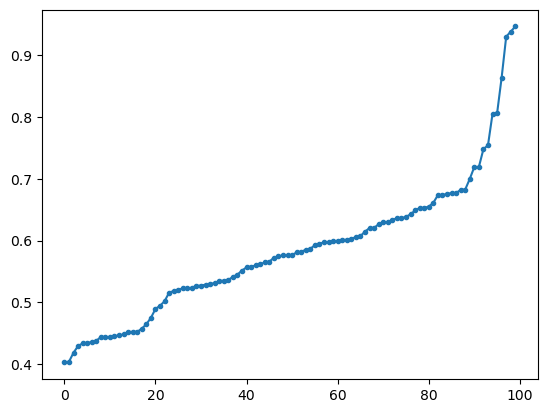

[12 23 25 50 61 75 88 89]
(24, 22)


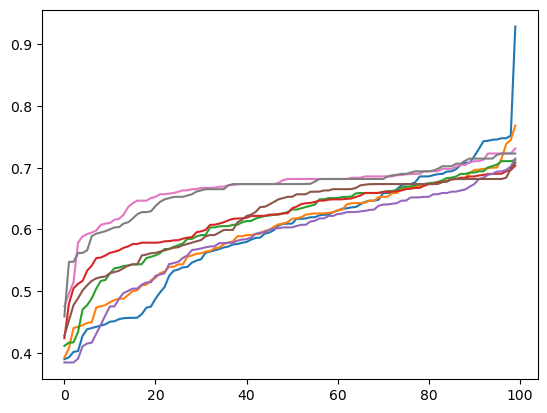

[0.82851226]
[ 49 132]
[0.5022606785108892, 0.6971973057988599]


/users/c/p/cpetak/miniconda3/envs/ca_grn/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


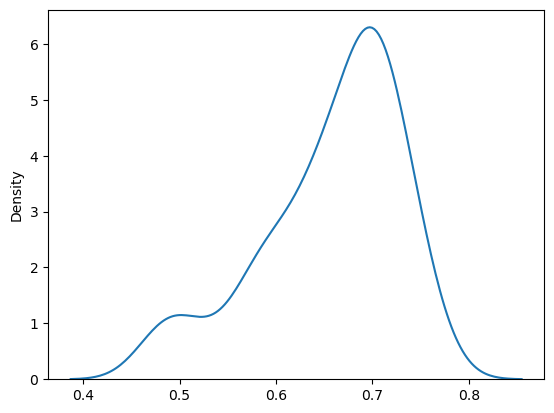

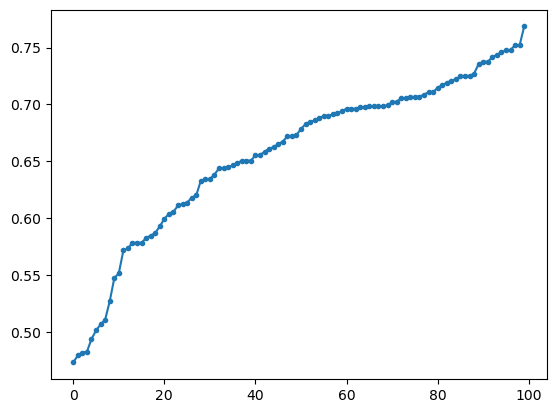

[19 46 66 91]
(24, 22)


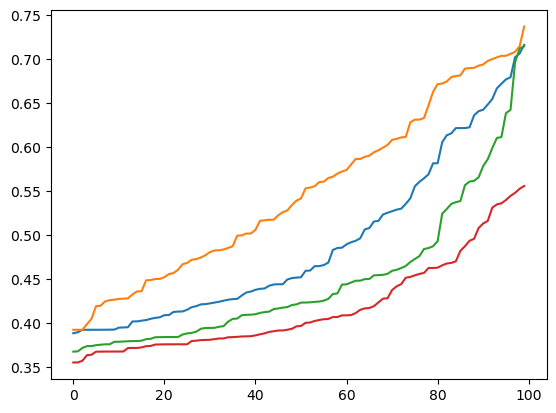

[0.80165067]
[ 54 125]
[0.4558546052094136, 0.6358532032927506]


/users/c/p/cpetak/miniconda3/envs/ca_grn/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


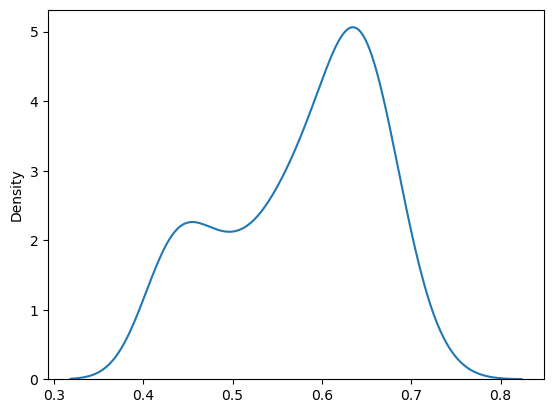

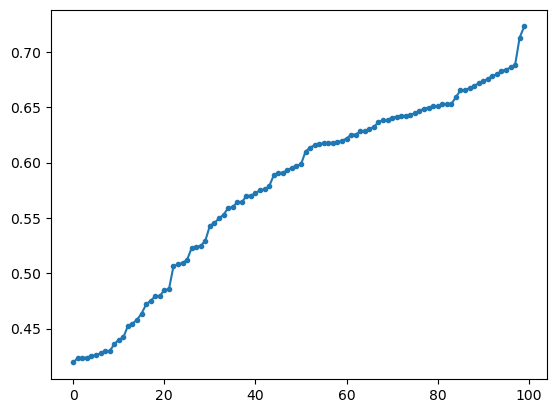

[ 8 33 54 76]
(24, 22)


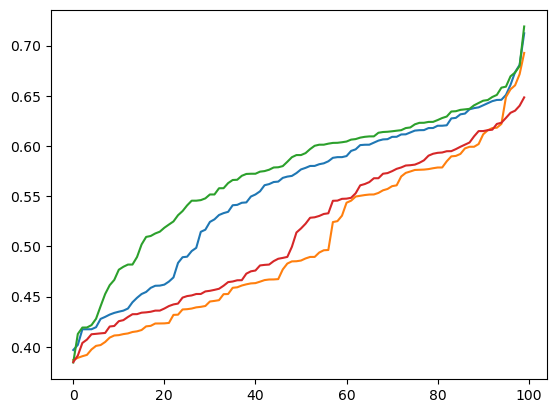

[0.81963706]
[ 27 147]
[0.45388275245855475, 0.6875257305490992]


/users/c/p/cpetak/miniconda3/envs/ca_grn/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


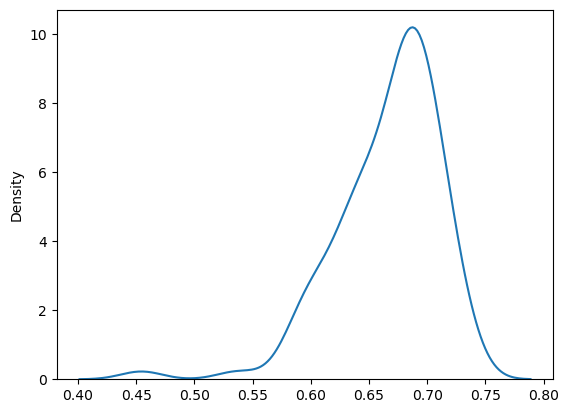

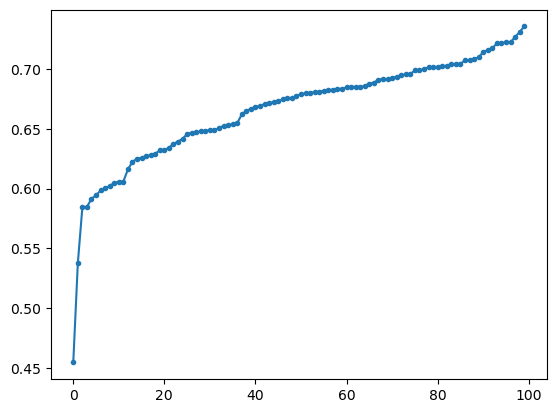

[94]
(24, 22)


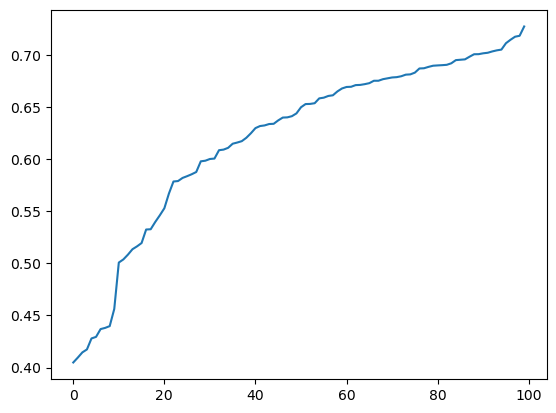

[0.82225722]
[ 72 109]
[0.6692062532995968, 0.7056061618832459]


/users/c/p/cpetak/miniconda3/envs/ca_grn/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


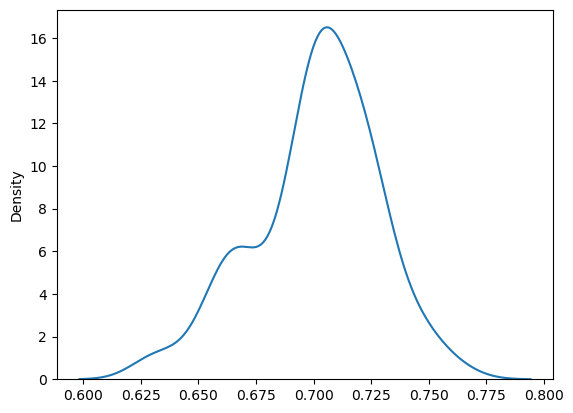

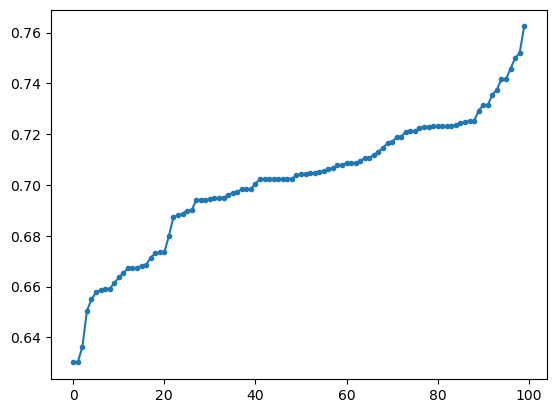

[ 2 18 52 58 68 81 82 87 91 92 93 95]
(24, 22)


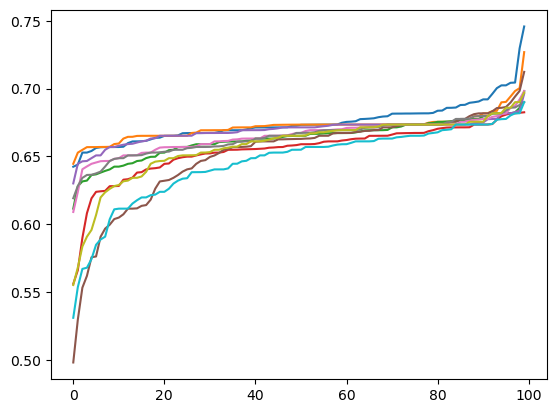

In [47]:
import seaborn as sns
from scipy.signal import find_peaks

int_reps = list(range(15))
for i in int_reps:
    grn_to_test = std_grns[i, -1, :, :]
    parent_fit, fitnesses, kids = make_kids(grn_to_test, gen = -1, mut_rate=1, mut_size=0.5)
    print(parent_fit)
    kde = sns.kdeplot(fitnesses)
    x = kde.lines[0].get_xdata()
    y = kde.lines[0].get_ydata()
    peaks, _ = find_peaks(y)
    print(peaks)
    print([x[p]for p in peaks])
    plt.show()
    plt.plot(sorted(fitnesses),".-")
    plt.show()
    candidates = np.where(np.abs(fitnesses - x[peaks[0]]) < 0.01)[0]
    print(candidates)
    print(kids[candidates[0]].shape)

    for c in candidates[:10]:
        parent_fit, fitnesses, kids = make_kids(kids[c], gen = -1, mut_rate=1., mut_size=0.5)
        plt.plot(sorted(fitnesses))
    plt.show()


In [6]:
def get_fit(grn_to_test, gen):

    seasons = np.tile(np.repeat([0, 1], 300), 100)[:9899]

    #calc phenos
    num_cells = 22
    dev_steps = 22
    inputs = []
    seeds = []
    for seed_int in seed_ints:
        #Make seeds, 1024 is one-hot
        start_pattern = helper.seedID2string(seed_int, num_cells)
        seeds.append(start_pattern)
        start_expression = helper.seed2expression(start_pattern, 1, num_cells, grn_size, geneid=1)
        inputs.append(start_expression)

    targets = []
    for idx, seed in enumerate(seeds):
        targets.append(helper.rule2targets_wrapped_wstart(int(rule), L=dev_steps+1, N=num_cells, start_pattern=seed))

    #parent pheno
    curr = seasons[gen]
    pheno = helper.develop(inputs[curr], np.expand_dims(grn_to_test, axis=0), dev_steps, 1, grn_size, num_cells)
    pheno=pheno[:,:,1::grn_size]

    worst= -num_cells*dev_steps
    prefitnesses = helper.fitness_function_ca(pheno, targets[curr])
    fitness=1-(prefitnesses/worst) #0-1 scaling

    return fitness

In [18]:
def make_path(grn_to_test, gen, mut_rate=0.1, mut_size=0.5):

    num_genes_mutate = int((grn_size + 2) * grn_size * 1 * mut_rate)
    
    p_fit = get_fit(grn_to_test, gen)

    kid = np.array(grn_to_test).copy()

    #take step
    mutations = np.random.randn(num_genes_mutate) * mut_size
    x, y = kid.shape
    xs = np.random.choice(x, size=num_genes_mutate)
    ys = np.random.choice(y, size=num_genes_mutate)
    kid[xs, ys] = kid[xs, ys] + mutations

    kid_fit = get_fit(kid, gen)

    counter = 0
    fits = [kid_fit]
    while kid_fit >= p_fit and counter < 100:
        counter +=1

        p_fit = kid_fit
        #take step
        mutations = np.random.randn(num_genes_mutate) * mut_size
        x, y = kid.shape
        xs = np.random.choice(x, size=num_genes_mutate)
        ys = np.random.choice(y, size=num_genes_mutate)
        kid[xs, ys] = kid[xs, ys] + mutations

        kid_fit = get_fit(kid, gen)
        fits.append(kid_fit)
    
    return counter, fits[:-1]

In [36]:
root="~/scratch/detailed_save/"
metric1 = "best_grn"
num_reps = 15
season_len=300
id_start = 0
seed_ints = [69904,149796]
grn_size = 22

rules = [22, 126, 154, 18, 122, 70,54,94,30,50,62,110,90,150,102]
rules = [102] #22,54,102 pretty high, 126,122,70,150 low, 154,18,94,30,62,110,90 medium

for rule in rules:
    print(rule)
    std_grns=[np.loadtxt(os.path.expanduser(root+f"variable/stats_{season_len}_{rule}-{rule}_69904-149796_{i+1+id_start}_{metric1}.txt")) for i in range(num_reps)]
    std_grns = np.array(std_grns)
    std_grns = np.reshape(std_grns, (num_reps, 9899,grn_size+2,grn_size))
    print(std_grns.shape)

102
(15, 9899, 24, 22)


In [37]:
from tqdm import tqdm

int_reps = list(range(15))
rep_paths = 100
gen = 100
counters = []
pfits = []

random_pop = np.random.randn(len(int_reps), grn_size+2, grn_size).astype(np.float64)

for i in tqdm(int_reps):
    grn_to_test = random_pop[i,:,:] #std_grns[i, gen, :, :]
    #parent_fit, fitnesses, kids = make_kids(grn_to_test, gen = -1, mut_rate=1, mut_size=0.5)
    parent_fit = get_fit(grn_to_test, gen)

    cs=[]
    for j in range(rep_paths):
        counter, kid_fits = make_path(grn_to_test, gen, mut_rate=0.1, mut_size=0.5)
        cs.append(counter)
    
    counters.append(sum(cs)/len(cs))
    pfits.append(parent_fit)
    

100%|██████████| 15/15 [00:09<00:00,  1.57it/s]


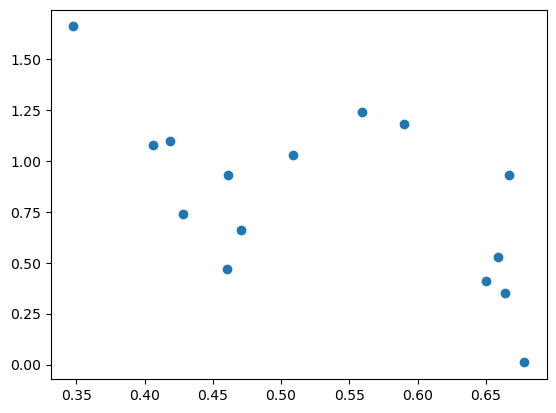

In [39]:
plt.scatter(pfits, counters)